# Heuristics

We evaluated the performance of multiple heuristics for the three objectives. Here we compare there relative performance.

For evaluating the performance of heuristics, we have the following problem:
* Most importantly, we are interested in the objective value achieved within a timelimit.
* Different instances can have very different objective values for the same instance size. So we cannot simply plot the objective values as this would tell us everything.
* We need relativ values. Best, how much we are above the optimal objective value.
* However, instances for which we can still compute optimal solutions, are not very interesting for evaluating heuristics.
* A compromise is, to compare the difference to the best objective value for this instance known to us. I.e., objective of heuristic/best known objective (for each instance individually)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
sns.set_theme()

# Configuration

In [3]:
# To quickly change the scaling of the plots
scaling = 0.7

In [4]:
# Selecting the solver to compare
solver_to_compare = {
    'MS': [ 
            'Greedy (MS)',
            'CP-1 (MS)',
            'GA (MS)',
            'APX (MS)'
          ],
    'TE': [ 
            'Greedy (TE)',
            'APX (TE,BE)',
            'CP-1 (MS)',
            'GA (TE)'
          ],
    'BE': [ # For BE we noted that the optimizer for MS and TE often yielded better results
            'Greedy (BE)',
            'GA (BE)',
            'APX (TE,BE)',
            'CP-1 (MS)',
            'GA (TE)'
          ]
}

# Load the experimental data

In [5]:
instances = pd.read_json("./data/instances.json")
instances.sample(5)

,graph_id,vertices_amount,edges_amount,instance_type,instance
453,454,17,102,celestial,See sqllite database using graph_id
231,232,11,26,celestial,See sqllite database using graph_id
935,936,29,304,celestial,See sqllite database using graph_id
1257,1258,39,291,random,See sqllite database using graph_id
1337,1338,44,393,random,See sqllite database using graph_id


In [6]:
solutions = pd.read_json("./data/solutions.json")
solutions.sample(10)

,graph_id,solution_id,MS,TE,BE,solver_type,solver,solution_type,date,runtime,has_optimality_certificate,solution
21722,1053,27812,666.429580,7924.417011,584.135543,SA,SA (MS),MS,2020-12-21 15:10:03.797289,46.271238,False,See sqlite database using solution_id
18068,893,5062,1031.947960,15519.272358,772.025332,Greedy,Greedy (MS),MS,2020-08-13 12:34:18.109511,13.532323,False,See sqlite database using solution_id
26016,1312,30837,1204.875453,15574.480681,888.843518,APX,APX (TE),TE,2021-01-02 18:22:31.944864,1.133281,False,See sqlite database using solution_id
34985,1911,48487,867.730982,27918.463490,677.170696,SA,SA (MS),MS,2021-01-22 19:28:06.271654,229.800760,False,See sqlite database using solution_id
7904,358,6127,432.733706,2728.012960,351.638672,MIP-1,MIP-1 (MS),MS,2020-08-13 12:34:18.109758,900.003011,False,See sqlite database using solution_id
682,27,1956,340.435188,579.411997,145.281783,MIP-1,MIP-1 (BE),BE,2020-08-07 19:18:42.638236,0.006025,True,See sqlite database using solution_id
32171,1716,41732,532.186808,2871.018468,379.081697,Greedy,Greedy (MS),MS,2021-01-08 18:18:34.317548,0.018191,False,See sqlite database using solution_id
29132,1529,32654,1185.686992,17289.540917,810.503626,ILS,ILS (BE),BE,2021-01-02 18:23:50.601154,0.526076,False,See sqlite database using solution_id
13908,674,6443,NaN,NaN,854.994416,MIP-1,MIP-1 (MS),MS,2020-08-13 12:34:18.109758,900.004049,False,See sqlite database using solution_id
31834,1700,41566,1122.379579,1699.998417,280.811455,MIP-1,MIP-1 (TE),TE,2021-01-08 17:57:05.947361,900.013410,False,See sqlite database using solution_id


In [7]:
# Available solver
solutions["solver"].replace({"APX (TE)": "APX (TE,BE)"}, inplace=True) # APX is actually TE and BE, so we rename these entry to make it clear.
solutions["solver"].unique()

array(['Greedy (TE)', 'MIP-3 (TE)', 'CP-2 (TE)', 'MIP-1 (TE)',
       'MIP-3 (BE)', 'MIP-1 (BE)', 'CP-2 (BE)', 'Greedy (BE)',
       'Greedy (MS)', 'MIP-1 (MS)', 'MIP-2 (MS)', 'CP-1 (MS)',
       'APX (TE,BE)', 'GA (TE)', 'APX (MS)', 'GA (BE)', 'GA (MS)',
       'ILS (BE)', 'ILS (MS)', 'ILS (TE)', 'SA (MS)', 'SA (TE)',
       'SA (BE)'], dtype=object)

# Find the best known solution for each instance in the solutions

In [8]:
best_known_solutions = solutions.groupby(["graph_id"])[["MS", "TE", "BE"]].min()
best_known_solutions.sample(5)

,MS,TE,BE
graph_id,,,
930,602.976424,9082.170763,376.483503
1771,445.930162,5674.148842,423.513711
104,263.634280,1083.204143,168.815940
60,252.266896,900.000000,149.338205
1153,479.236178,2447.319390,242.172442


# Compute the relative objectives of each solution
That is, the objective value divided by the best known.

In [9]:
relative_objectives = solutions.merge(best_known_solutions, left_on="graph_id", right_index=True, suffixes=("", "_best"))
relative_objectives.sample(5)

,graph_id,solution_id,MS,TE,BE,solver_type,solver,solution_type,date,runtime,has_optimality_certificate,solution,MS_best,TE_best,BE_best
20658,1008,18143,NaN,NaN,544.948298,MIP-1,MIP-1 (BE),BE,2020-08-25 10:26:13.416057,900.004169,False,See sqlite database using solution_id,388.714558,3320.573810,380.472894
21208,1027,18114,NaN,NaN,469.824089,MIP-3,MIP-3 (BE),BE,2020-08-25 10:26:13.415984,900.074245,False,See sqlite database using solution_id,409.326334,3557.870423,287.335406
33613,1785,40773,1322.502484,9989.814954,960.014360,APX,"APX (TE,BE)",TE,2021-01-08 17:56:30.870112,1.659329,False,See sqlite database using solution_id,481.029316,6227.417079,458.110443
1751,68,2637,259.249410,960.140984,249.075532,Greedy,Greedy (BE),BE,2020-08-07 19:18:42.638041,0.001150,False,See sqlite database using solution_id,245.169280,727.916740,161.317643
24281,1203,37245,1551.671305,3700.263610,361.912111,GA,GA (TE),TE,2021-01-07 23:07:59.261928,45.409833,False,See sqlite database using solution_id,438.274287,3700.263610,361.912111


In [10]:
for obj in ["MS", "TE", "BE"]:
    relative_objectives[f"{obj}_relative"]=relative_objectives[obj]/relative_objectives[f"{obj}_best"]
relative_objectives.sample(5)

,graph_id,solution_id,MS,TE,BE,solver_type,solver,solution_type,date,runtime,has_optimality_certificate,solution,MS_best,TE_best,BE_best,MS_relative,TE_relative,BE_relative
16546,812,39375,1738.376296,11614.406827,648.715574,ILS,ILS (TE),TE,2021-01-07 23:48:02.928326,0.288059,False,See sqlite database using solution_id,564.793088,7535.258815,371.299657,3.077899,1.541341,1.747148
2498,97,1057,740.973608,1065.935357,213.542886,MIP-3,MIP-3 (TE),TE,2020-08-03 10:30:19.743764,900.009396,False,See sqlite database using solution_id,299.030314,1065.935357,171.608314,2.477921,1.000000,1.244362
18674,924,42170,591.450745,14242.169544,587.165694,CP-1,CP-1 (MS),MS,2020-08-13 12:34:18.111074,900.481793,False,See sqlite database using solution_id,591.450745,8386.865910,396.731988,1.000000,1.698152,1.480006
8657,397,25308,1116.423953,2507.030002,297.767934,GA,GA (TE),TE,2020-08-13 12:34:45.926394,9.699491,False,See sqlite database using solution_id,316.972004,2398.959070,166.279376,3.522153,1.045049,1.790769
22148,1078,39641,1306.323623,7535.795235,657.841320,Greedy,Greedy (TE),TE,2021-01-08 17:34:25.565050,0.054007,False,See sqlite database using solution_id,433.184517,6098.889189,383.736996,3.015629,1.235601,1.714303


# Combine solutions and instances for plotting into a single table

We want to use the number of edges as x-axis so we have to add it to the solutions

In [11]:
results = relative_objectives.merge(instances, left_on="graph_id", right_on="graph_id")[["edges_amount", "solver", "graph_id", "instance_type", "solution_id", "MS_relative", "TE_relative", "BE_relative"]]
results

,edges_amount,solver,graph_id,instance_type,solution_id,MS_relative,TE_relative,BE_relative
0,15,Greedy (TE),1,celestial,1,1.307590,1.525635,1.549312
1,15,MIP-3 (TE),1,celestial,961,2.025135,1.000000,1.000000
2,15,CP-2 (TE),1,celestial,1281,2.030920,1.000000,1.000000
3,15,MIP-1 (TE),1,celestial,1475,3.555082,1.000000,1.000000
4,15,MIP-3 (BE),1,celestial,1770,1.738130,1.043021,1.000000
...,...,...,...,...,...,...,...,...
27827,779,APX (MS),2141,celestial,46627,2.511200,1.612232,1.759224
27828,779,CP-1 (MS),2141,celestial,46824,1.000000,1.000000,1.000000
27829,779,ILS (MS),2141,celestial,47612,1.644209,1.053842,1.294000
27830,779,SA (MS),2141,celestial,47809,1.644209,1.053842,1.294000


# How many solutions are there per solver and instance type?

Note that some solver have only few entries because they did not convince and were not scheduled for the final evaluations. Also, some results prior results have been accidentally deleted. Especially on SA (that also wasn't convincing).

In [12]:
results.groupby(["instance_type", "solver"])["graph_id"].nunique()

instance_type  solver     
celestial      APX (MS)       1127
               APX (TE,BE)    1085
               CP-1 (MS)      1127
               CP-2 (BE)       960
               CP-2 (TE)       160
               GA (BE)        1085
               GA (MS)        1127
               GA (TE)        1085
               Greedy (BE)    1085
               Greedy (MS)    1127
               Greedy (TE)    1085
               ILS (BE)        285
               ILS (MS)       1002
               ILS (TE)       1085
               MIP-1 (BE)      160
               MIP-1 (MS)     1085
               MIP-1 (TE)      135
               MIP-2 (MS)      510
               MIP-3 (BE)      160
               MIP-3 (TE)      160
               SA (BE)         125
               SA (MS)          42
               SA (TE)         125
random         APX (MS)        804
               APX (TE,BE)     706
               CP-1 (MS)       771
               CP-2 (BE)        88
               CP-2 (TE)    

# Provide functions to filter the comparable results that have been solved by all solvers we want to compare

There are a lot of experiments.
Many of them only considered a single solver.
However, we can only compare results for instances that have been solved by all solver.

Note that if a solver was not able to compute valid solution within the given time, a random solution is assigned.
In our experiments, this did not happen for the instance sizes considered here.

In [13]:
def _graph_ids_solved_by_all(solvers: list) -> list:
    """
    Returns a list with all graph ids for which all the specified solvers provide a solution.
    This is important to make sure, the results are comparable.
    """
    solvers_for_graph_id = solutions.groupby(["graph_id"])["solver"].unique()
    def are_superset(s):
        return set(solvers).issubset(set(s))
    return list(solvers_for_graph_id[solvers_for_graph_id.apply(are_superset)].index)

# Aggregation: +-x% rolling window

We cannot compute values for every size.
However, in order to compute some partly stable averages, standard deviations, etc., we need multiple entries.
Here, we provide some functionality to simply aggregate the results over some +- percentage.
Unfortunately, I didn't find a native function for that.

In [14]:
def _get_rolled_data(data, on, relative_pm_deviation, step_size=1, name_of_rolled_index="x" ,min_size=1):
    min_x = int(data[on].min())
    max_x = int(data[on].max())
    tables = []
    for x in range(min_x, max_x+step_size, step_size):
        t = data[data[on].apply(lambda x_: math.floor((1-relative_pm_deviation)*x) <= x_ <= math.ceil((1+relative_pm_deviation)*x))].copy()
        t[name_of_rolled_index]=x
        if len(t)>=min_size:
            tables.append(t)
    t = pd.concat(tables)
    return t

## Example
### Without aggregation

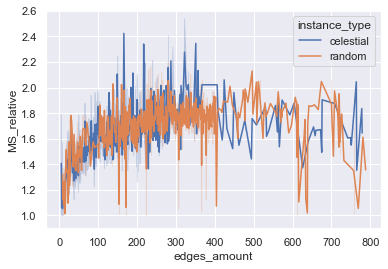

In [15]:
t = relative_objectives[relative_objectives["solver"]=="Greedy (MS)"].merge(instances, left_on="graph_id", right_on="graph_id")
sns.lineplot(data=t, x="edges_amount", y="MS_relative", hue="instance_type")
plt.gca().set_ylim(0.9, 2.6)
plt.show()

### With +-5% aggregation

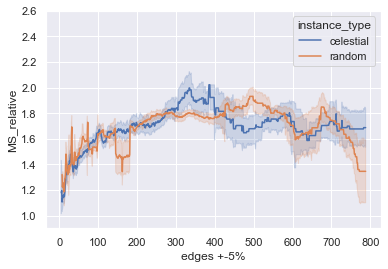

In [16]:
t_rolled = _get_rolled_data(t, on="edges_amount", relative_pm_deviation=0.05, name_of_rolled_index="edges +-5%")
sns.lineplot(data=t_rolled, x="edges +-5%", y="MS_relative", hue="instance_type")
plt.gca().set_ylim(0.9, 2.6)
plt.show()

# Plotting

We plot the plots side by side so only the first plot gets y-labels to save space.
For this, we of course had to fix the y-range.

![aligned plots](static/aligned_heuristic.png)

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

In [83]:
def plot(data, width, filename, hide_ylabels=False, xlim=None, bbox_to_anchor=(1.2, 1.0), palette=None, show_legend=True):
    plt.figure(figsize=(scaling*width,scaling* 6*(5.5/6)))
    ax = plt.gca()
    if palette:
        g = sns.lineplot(data=data, x="x", y="y", hue="Solver", style="Type", ax=ax, palette=palette)
    else:
        g = sns.lineplot(data=data, x="x", y="y", hue="Solver", style="Type", ax=ax)
    plt.ylabel("Relative objective value")
    plt.xlabel("Number of edges $+/-5\%$")
    if show_legend:
        plt.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor)
    else:
        ax.get_legend().remove()
    if xlim:
        plt.xlim(*xlim)
    plt.ylim(0.95, 3.2)
    if hide_ylabels:
        plt.gca().get_yaxis().set_ticklabels([])
        plt.ylabel(None)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    for ext in ["pdf", "png"]:
        plt.savefig(f"./output/{filename}.{ext}", dpi=300)
    plt.show()

In [19]:
def get_data(obj):
    tables = []
    graph_ids = _graph_ids_solved_by_all(solver_to_compare[obj]) # The graph ids that have the sufficient solutions
    # create rolled data for every instance/solver combination individually.
    for instance_type in ["random", "celestial"]:
        for solver in solver_to_compare[obj]:
            t = results[(results["solver"]==solver) & (results["instance_type"]==instance_type)]
            t = t[t["graph_id"].isin(graph_ids)]
            t = _get_rolled_data(t, on="edges_amount", relative_pm_deviation=0.05, name_of_rolled_index="x", min_size=3)
            tables.append(t)
    data = pd.concat(tables)
    data.rename(columns={f"{obj}_relative": "y", "solver": "Solver", "instance_type": "Type"}, inplace=True)
    data.sort_values(["x", "Solver"], inplace=True, kind='mergesort')
    data.sort_values(["Type"], inplace=True, ascending=False,kind='mergesort')
    return data

## Makespan

In [51]:
data_ms = get_data("MS")

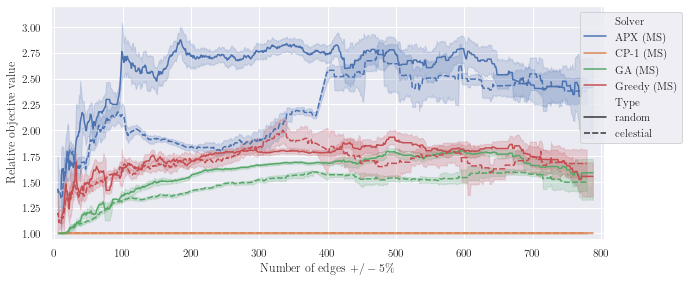

In [106]:
#data_ms[data_ms["x"].apply(lambda x: 10<=x<=800)]
plot(data_ms,width=13.5, hide_ylabels=False, filename="heuristic_relative_makespan", bbox_to_anchor=(1.15, 1.0), xlim=(-5, 805))

You may notice the drop in the end. This is because the especially the genetic algorithm now is terminated early by the timelimit. Because it is written in Python, it is relatively slow.

## Total Energy

In [56]:
data_te = get_data("TE")

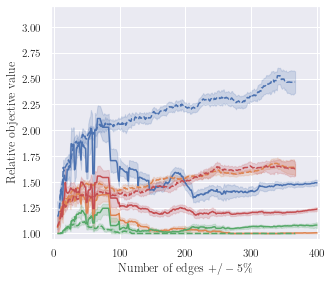

In [104]:
#data_te[data_te["x"].apply(lambda x: 10<=x<=400)]
plot(data_te, width=6.5, hide_ylabels=False, filename="heuristic_relative_total_energy", xlim=(-5, 405), show_legend=False)

## Bottleneck Energy

In [53]:
data_be = get_data("BE")

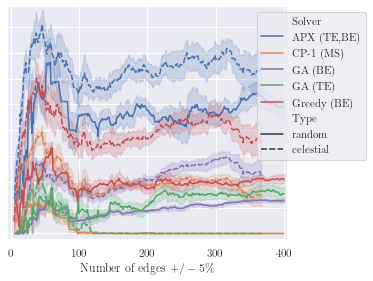

In [110]:
#data[data["x"].apply(lambda x: 10<=x<=400)]
palette = sns.color_palette([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[4], sns.color_palette()[2], sns.color_palette()[3]])
plot(data_be, width=7.35, hide_ylabels=True, filename="heuristic_relative_bottleneck_energy", xlim=(-5, 405), palette=palette, bbox_to_anchor=(1.3, 1.0))

In [76]:
palette = sns.color_palette([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[3]])
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]